In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 46s 600ms/step - loss: 0.1518 - root_mean_squared_error: 0.3896 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1802
Epoch 2/50
53/53 [==============================] - 2s 38ms/step - loss: 0.0637 - root_mean_squared_error: 0.2525 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1883
Epoch 3/50
53/53 [==============================] - 31s 597ms/step - loss: 0.0495 - root_mean_squared_error: 0.2226 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1663
Epoch 4/50
53/53 [==============================] - 32s 612ms/step - loss: 0.0375 - root_mean_squared_error: 0.1937 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1463
Epoch 5/50
53/53 [==============================] - 33s 625ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232
Epoch 6/50
53/53 [==============================] - 32s 605ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0127 - 

53/53 [==============================] - 38s 739ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 41/50
53/53 [==============================] - 4s 68ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 42/50
53/53 [==============================] - 44s 840ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020
Epoch 43/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 44/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0116 - root_mean_squared_error: 0.1075 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 45/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063 - val_loss: 0.0120 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.877115841706594 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

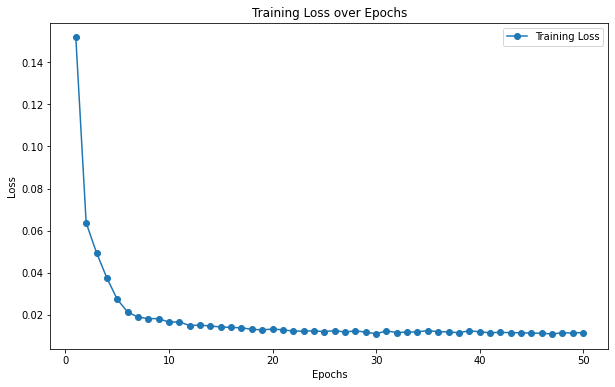

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

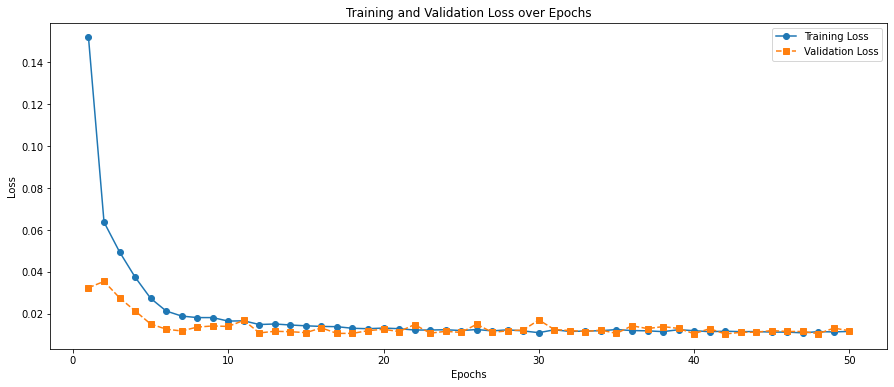

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 3s 32ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09965610359624928
MAE : 0.07893270355867837


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,482541.000000,605897.837
1,594295.875000,654073.790
2,629141.187500,701143.910
3,598816.812500,657891.340
4,518304.937500,432215.421
5,363554.187500,201834.787
6,148197.234375,55041.511
7,26139.802734,5387.468
8,-11178.570312,1576.813
9,58776.914062,21681.895


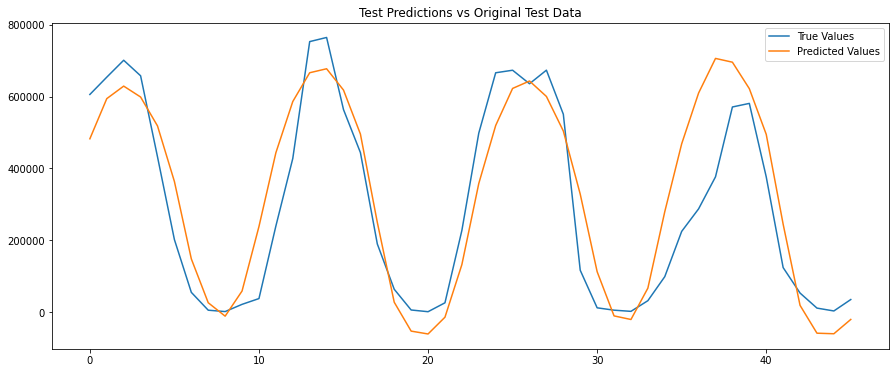

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 39ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

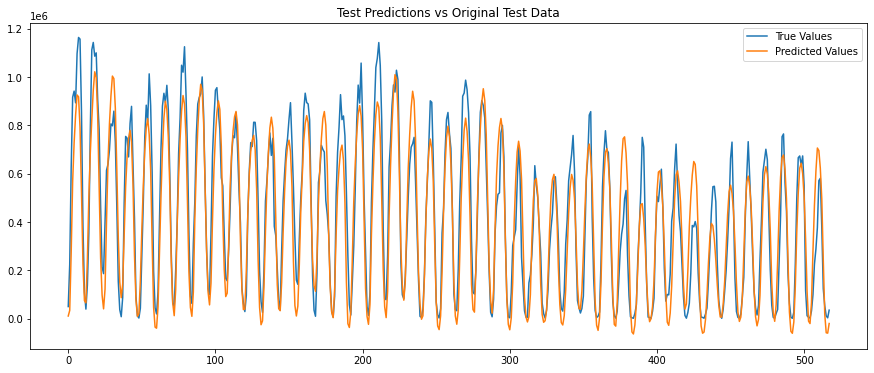

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()